In [35]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # математические функции и матрицы
import matplotlib.pyplot as plt # графики
import statsmodels.api as sm # стандартные регрессионные модели
import statsmodels.formula.api as smf # аналогичные модели с синтаксисом в стиле R
import statsmodels.graphics.gofplots as gf # визуализация моделей
import statsmodels.discrete.discrete_model # дискретные модели
from statsmodels.stats.outliers_influence import summary_table # работа с выбросами
from scipy.stats import shapiro # тест Шапиро – Уилка
import math
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy import stats
from scipy.stats import f
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

from tests import (
    test_normality, 
    calculate_vif, 
    calculate_condition_indices, 
    chow_test_for_dummies, 
    test_heteroskedasticity, 
    test_ramsey, 
    plot_correlation_matrix, 
    plot_residuals_vs_fitted, 
    plot_qq_residuals, 
    f_test_joint_significance
)

In [37]:
df = pd.read_csv('cars_clean_clean')
df

,Unnamed: 0.1,Unnamed: 0,brand,color,color_group,gearbox,drive,fuel_type,city,city_group,...,power_2,model_popularity,age,generation,is_new,is_restyling,is_pro,is_max,is_premium,price
0,0,0,Haval,серый,Нейтральные,робот,полный,Бензин,Москва,Москва,...,177.0,4.0,1.0,1,False,0,0,0,0,2320000.0
1,1,1,Chery,серый,Нейтральные,механика,передний,Бензин,Москва,Москва,...,113.0,270.0,1.0,1,False,0,1,0,0,1490000.0
2,2,2,Haval,чёрный,Нейтральные,робот,полный,Бензин,Москва,Москва,...,177.0,4.0,1.0,1,False,0,0,0,0,2650000.0
3,3,3,Geely,синий,Холодные,робот,передний,Бензин,Балашиха,Московская область,...,200.0,7.0,2.0,1,False,1,0,0,0,2980000.0
4,4,4,Chery,серый,Нейтральные,робот,передний,Бензин,Москва,Москва,...,147.0,270.0,3.0,1,False,1,0,0,0,1500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1310,1310,Geely,серебристый,Нейтральные,автомат,полный,Бензин,Москва,Москва,...,238.0,319.0,0.0,1,False,1,0,0,1,3830000.0
1311,1311,1311,Geely,голубой,Холодные,робот,передний,Бензин,Москва,Москва,...,181.0,80.0,1.0,1,False,0,0,0,0,2699999.0
1312,1312,1312,Geely,серый,Нейтральные,робот,передний,Бензин,Москва,Москва,...,181.0,80.0,1.0,1,False,0,0,0,0,2699999.0
1313,1313,1313,Geely,синий,Холодные,робот,полный,Бензин,Одинцово,Московская область,...,177.0,132.0,3.0,1,False,0,1,0,0,2100000.0


In [4]:
#pip install xlrd==1.2.0

In [38]:
selected_features = ['log_age', 
               'brand_Geely', 
               'is_restyling', 
               'color_group_Холодные', 
               'log_power_2', 
               'city_group_Москва', 
               'gearbox_механика', 
               'drive_полный',
               'car_class_Crossover']
numeric_feats = ['mileage', 'power_1', 'power_2', 'age']
cat_feats = ['brand', 'color_group', 'gearbox', 'drive', 'fuel_type', 'city_group', 'car_class']
dummies = ['is_restyling', 'is_pro', 'is_max', 'is_premium']
target = 'price'

In [39]:
def prepare_data(df, target_col, categorical_cols, numeric_cols=None, dummies=None):
    """Подготовка данных с обработкой категориальных и числовых признаков"""
    # Создание dummy-переменных
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, 
                            columns=encoder.get_feature_names_out(categorical_cols))
    
    # Обработка числовых признаков
    if numeric_cols is None:
        numeric_cols = df.drop(columns=[target_col] + categorical_cols).columns
    
    X_numeric = df[numeric_cols].copy()
    X_dum = df[dummies].copy()
    
    # Создание преобразованных признаков
    X_transformed = pd.DataFrame()
    for col in numeric_cols:
        X_transformed[f'log_{col}'] = np.log1p(X_numeric[col])
        X_transformed[f'sq_{col}'] = X_numeric[col]**2
    
    # Объединение всех признаков
    X = pd.concat([X_numeric, X_transformed, encoded_df, X_dum], axis=1)
    y = df[target_col]
    
    return X, y, np.log1p(y), encoder

In [40]:
# Подготовка данных
X_full, y, target_log, encoder = prepare_data(df, target, cat_feats, numeric_feats, dummies)

Модель, которую оценивали ранее:

In [41]:
X_final = sm.add_constant(X_full[selected_features])

In [42]:
X_for_final = sm.add_constant(X_full[selected_features])
model_linear_final = sm.OLS(target_log, X_for_final).fit()  
print(model_linear_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1218.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        19:09:07   Log-Likelihood:                 355.17
No. Observations:                1315   AIC:                            -690.3
Df Residuals:                    1305   BIC:                            -638.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.3904 

Допустим, мы хотим посмотреть на другие спецификации моделей с тем же набором признаков

In [43]:
scaler = StandardScaler()  #отнормируем все не-дамми
X_final['age'] = df['age']
X_final['power_2'] = df['power_2']
X_final[['age_scaled', 'power_2_scaled']] = scaler.fit_transform(X_final[['age', 'power_2']])
X_final[['log_age_scaled', 'log_power_2_scaled']] = scaler.fit_transform(X_final[['log_age', 'log_power_2']])

In [44]:
selected_features_linear = ['age_scaled',
               'brand_Geely', 
               'is_restyling', 
               'color_group_Холодные', 
               'power_2_scaled', 
               'city_group_Москва', 
               'gearbox_механика', 
               'drive_полный',
               'car_class_Crossover']

selected_features = ['log_age_scaled', 
               'brand_Geely', 
               'is_restyling', 
               'color_group_Холодные', 
               'log_power_2_scaled', 
               'city_group_Москва', 
               'gearbox_механика', 
               'drive_полный',
               'car_class_Crossover']

y = y
target_log = target_log

In [45]:
# Обучение трех моделей
linear_model = sm.OLS(y, X_final[selected_features_linear]).fit()
prtly_log_model = sm.OLS(target_log, X_final[selected_features_linear]).fit()
linear_log_model = sm.OLS(target_log, X_final[selected_features]).fit()

In [13]:
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              2308.
Date:                Thu, 08 May 2025   Prob (F-statistic):                        0.00
Time:                        19:06:22   Log-Likelihood:                         -19401.
No. Observations:                1315   AIC:                                  3.882e+04
Df Residuals:                    1306   BIC:                                  3.887e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [46]:
print(prtly_log_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              1899.
Date:                Thu, 08 May 2025   Prob (F-statistic):                        0.00
Time:                        19:09:17   Log-Likelihood:                         -3648.1
No. Observations:                1315   AIC:                                      7314.
Df Residuals:                    1306   BIC:                                      7361.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [15]:
print(linear_log_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              1980.
Date:                Thu, 08 May 2025   Prob (F-statistic):                        0.00
Time:                        19:06:29   Log-Likelihood:                         -3622.6
No. Observations:                1315   AIC:                                      7263.
Df Residuals:                    1306   BIC:                                      7310.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [16]:
# Сравним AIC и BIC
print('Log-Log   : AIC=', linear_log_model.aic, '  BIC=', linear_log_model.bic)
print('Log-Lin   : AIC=', prtly_log_model.aic, '  BIC=', prtly_log_model.bic)
print('Lin-Lin   : AIC=', linear_model.aic, '  BIC=', linear_model.bic)

Log-Log   : AIC= 7263.199446019136   BIC= 7309.833773520643
Log-Lin   : AIC= 7314.131055020845   BIC= 7360.765382522352
Lin-Lin   : AIC= 38820.98117613847   BIC= 38867.61550363998


По информационным критериям очевидно, что линейная модель сильно уступает моделям с логарифмами. По этому критерию выигрывает линейная в логарифмах модель (которую мы оценивали ранее). Давайте посмотрим на VIF

In [17]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_final[selected_features_linear].columns
vif_data["VIF"] = [variance_inflation_factor(X_final[selected_features_linear].values, i) for i in range(X_final[selected_features_linear].shape[1])]

high_vif_features = vif_data[vif_data["VIF"] > 10]
print("\nОтсортировано по VIF (по убыванию):\n", high_vif_features.sort_values("VIF", ascending=False))


Отсортировано по VIF (по убыванию):
 Empty DataFrame
Columns: [feature, VIF]
Index: []


In [18]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_final[selected_features].columns
vif_data["VIF"] = [variance_inflation_factor(X_final[selected_features].values, i) for i in range(X_final[selected_features].shape[1])]

high_vif_features = vif_data[vif_data["VIF"] > 10]
print("\nОтсортировано по VIF (по убыванию):\n", high_vif_features.sort_values("VIF", ascending=False))


Отсортировано по VIF (по убыванию):
 Empty DataFrame
Columns: [feature, VIF]
Index: []


In [19]:
y_boxcox, fitted_lambda = boxcox(y)
print("Оптимальный лямбда:", fitted_lambda)

Оптимальный лямбда: 0.9095779949670135


Ситуация интересная, давайте изучим полулог модель:

In [20]:
#  остатки

linear_resids = y -linear_model.predict(X_final[selected_features_linear])
part_log_resids = target_log -prtly_log_model.predict(X_final[selected_features_linear])
lin_log_resids = target_log -linear_log_model.predict(X_final[selected_features])

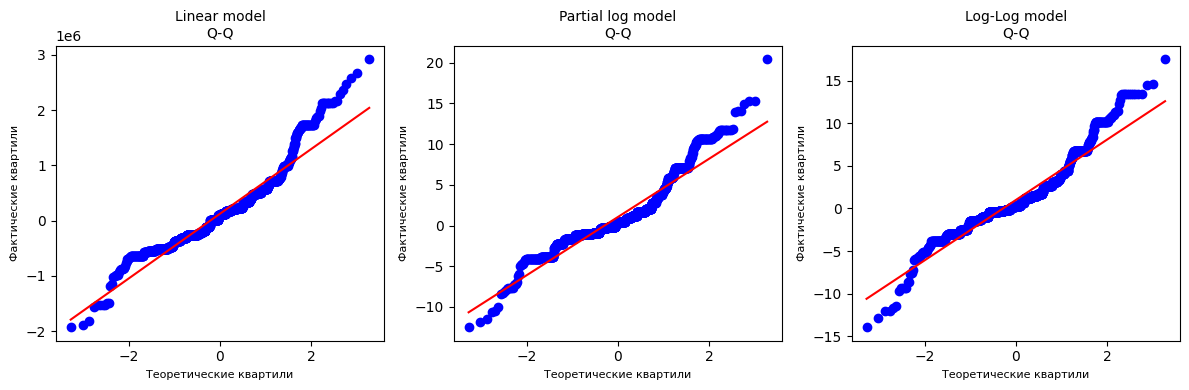

In [21]:
def plot_qq_residuals(residuals, ax, title='Q-Q Plot'):
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.get_lines()[1].set_color('red')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Теоретические квартили", fontsize=8)
    ax.set_ylabel("Фактические квартили", fontsize=8)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_qq_residuals(linear_resids, axes[0], title='Linear model\nQ-Q')
plot_qq_residuals(part_log_resids, axes[1], title='Partial log model\nQ-Q')
plot_qq_residuals(lin_log_resids, axes[2], title='Log-Log model\nQ-Q')

plt.tight_layout()
plt.show()

In [22]:
test_normality(linear_resids)

,Shapiro-Wilk Test,Jarque-Bera Test,Kolmogorov-Smirnov Test
0,0.0,0.0,0.0


In [23]:
test_normality(part_log_resids)

,Shapiro-Wilk Test,Jarque-Bera Test,Kolmogorov-Smirnov Test
0,0.0,0.0,0.0


In [24]:
test_normality(lin_log_resids)

,Shapiro-Wilk Test,Jarque-Bera Test,Kolmogorov-Smirnov Test
0,0.0,0.0,0.0


Эти остатки не нормальны.

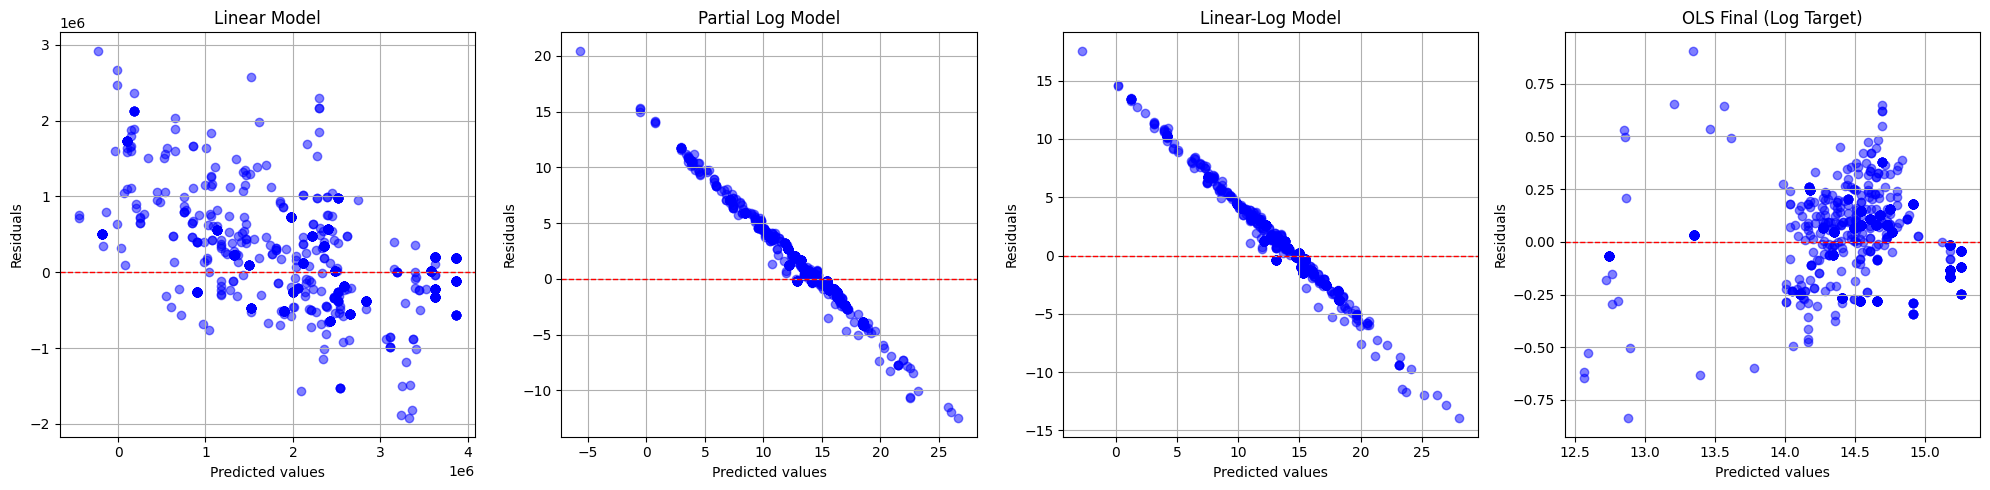

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Функция для графиков остатков
def plot_residuals_vs_fitted(model, X, y, ax, title):
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.5, color='blue')
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('Residuals')
    ax.set_title(title)
    ax.grid(True)

# Создаем 4 графика в одной строке (теперь их 4)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1. Линейная модель (без логарифма)
plot_residuals_vs_fitted(linear_model, X_final[selected_features_linear], y, axes[0], 'Linear Model')

# 2. Частично логарифмированная модель
plot_residuals_vs_fitted(prtly_log_model, X_final[selected_features_linear], target_log, axes[1], 'Partial Log Model')

# 3. Линейно-логарифмическая модель
plot_residuals_vs_fitted(linear_log_model, X_final[selected_features], target_log, axes[2], 'Linear-Log Model')

# 4. Новая модель: OLS с логарифмированной целевой переменной
plot_residuals_vs_fitted(model_linear_final, X_for_final, target_log, axes[3], 'OLS Final (Log Target)')

plt.tight_layout()
plt.show()



Тест бокс кокса с преобразованием зарембки. Сравним линейную и лин-лог модель с скейлингом

In [ ]:
def zarembka_test(model_linear, model_log):
    n = model_linear.nobs
    
    RSS_3 = np.sum(model_linear.resid ** 2)
    RSS_4 = np.sum(model_log.resid ** 2)
    
    chi2 = (n / 2) * np.abs(np.log(RSS_3 / RSS_4))
    return chi2, RSS_3, RSS_4

chi2, rss_lin, rss_log = zarembka_test(linear_model, linear_log_model)
print(f'chi^2 = {chi2:.3f}')
print(f'RSS (linear): {rss_lin:.3f}')
print(f'RSS (log): {rss_log:.3f}')

alpha = 0.05
chi2_crit = 3.84
if chi2 > chi2_crit:
    print("Значимое различие между моделями!")
else:
    print("Нет значимого различия между моделями.")


chi^2 = 15778.891
RSS (linear): 503037257747348.125
RSS (log): 19022.395
Значимое различие между моделями!


Теперь лин-лог со скейлингом и без скейлинга

In [50]:
chi2, rss_lin, rss_log = zarembka_test(linear_log_model, model_linear_final)
print(f'chi^2 = {chi2:.3f}')
print(f'RSS (linear): {rss_lin:.3f}')
print(f'RSS (log): {rss_log:.3f}')

alpha = 0.05
chi2_crit = 3.84
if chi2 > chi2_crit:
    print("Значимое различие между моделями!")
else:
    print("Нет значимого различия между моделями.")

chi^2 = 3977.770
RSS (linear): 19022.395
RSS (log): 44.859
Значимое различие между моделями!


PE тест

In [51]:
def mwd_test(y, X, linear_model, log_model):

    y = np.asarray(y)
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    
    y_hat = linear_model.fittedvalues
    logy_hat = log_model.fittedvalues
    exp_logy_hat = np.exp(logy_hat)
    
    aux1 = y_hat - exp_logy_hat
    aux2 = logy_hat - np.log(np.maximum(y_hat, 1e-10)) 

    lny = np.log(y)
    X_aux1 = sm.add_constant(np.column_stack((X, aux1)))
    aux1_model = sm.OLS(lny, X_aux1).fit()
    
    X_aux2 = sm.add_constant(np.column_stack((X, aux2)))
    aux2_model = sm.OLS(y, X_aux2).fit()
    
    print('=== Гипотеза H0: δ_LOG = 0 (лог-модель) ===')
    print(aux1_model.summary())
    print('\n=== Гипотеза H0: δ_LIN = 0 (линейная модель) ===')
    print(aux2_model.summary())
    
    results = {
        'delta_LOG_coef': aux1_model.params[-1],
        'delta_LOG_pvalue': aux1_model.pvalues[-1],
        'delta_LIN_coef': aux2_model.params[-1],
        'delta_LIN_pvalue': aux2_model.pvalues[-1],
        'log_model_summary': aux1_model.summary(),
        'linear_model_summary': aux2_model.summary()
    }
    return results


In [55]:
results = mwd_test(
    y,
    X_final[selected_features_linear],
    linear_model,
    linear_log_model
)
results

=== Гипотеза H0: δ_LOG = 0 (лог-модель) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1172.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        19:49:04   Log-Likelihood:                 395.07
No. Observations:                1315   AIC:                            -768.1
Df Residuals:                    1304   BIC:                            -711.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

{'delta_LOG_coef': np.float64(1.4039061148785498e-14),
 'delta_LOG_pvalue': np.float64(0.8993044342643413),
 'delta_LIN_coef': np.float64(36271.94310928008),
 'delta_LIN_pvalue': np.float64(1.454497690355646e-35),
 'log_model_summary': <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.900
 Model:                            OLS   Adj. R-squared:                  0.899
 Method:                 Least Squares   F-statistic:                     1172.
 Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
 Time:                        19:49:04   Log-Likelihood:                 395.07
 No. Observations:                1315   AIC:                            -768.1
 Df Residuals:                    1304   BIC:                            -711.1
 Df Model:                          10                                     

Тесты показывают необходимость логарифмирования признаков, также информационные тесты дали дополнительную уверенность в том, что выбранная нами ранее модель лучше.